# COS 463 Wireless Networks - Spring 2019
# Lab 2: Synchronization and MAC protocols

In class we've learned about different MAC (medium access control) protocols that determine when devices get to transmit (these protocols *control* *access* to the *medium*). For all but the simplest MAC protocols, the participating devices need to be synchronized in time. The way this is done in practice is to have one node transmit a signal (called a "preamble" or "beacon") and the other nodes will listen for this signal. Since wireless signals travel at the speed of light, all nodes can agree that they will hear the preamble at nearly exactly the same time.

First, we will explore how nodes can listen for a specific preamble to achieve time synchronization. Then, we will use this method to synchronize to a preamble using the HackRF hardware. Finally, we will wrap up with a Monte Carlo simulation of the capacities of the slotted-ALOHA MAC protocol.

In [1]:
%matplotlib notebook

from matplotlib import pyplot
import numpy
import SoapySDR
from SoapySDR import SOAPY_SDR_RX, SOAPY_SDR_CF32

# Part 1: Correlation and Preambles

A preamble is a waveform sent at the beginning of a packet that is used to indicate the start of a packet. The preamble waveform is agreed to ahead-of-time, so the signal carries no data. Receivers will listen for the preamble, and when it's detected the receivers will start to demodulate the rest of the packet. Preambles can also be used to synchronize multiple clients for MAC protocols that require synchronization.

In this part, we will explore how to detect and synchronize to a preamble. Both detection and synchronization can be done using a **correlation**. A correlation of two discrete signals $x$ and $y$ is an infinite-length discrete signal which is defined as
$$ (x \star y)[k] = \sum_{n = -\infty}^{\infty}x^*[n] \cdot y[n + k]$$
In other words, at each index $k$, you take conjugate of the first signal $x$ and offset the second signal $y$ by $k$ indices and then sum the resulting two signals. Intuitively, the correlation measures the similarity of two signals for every offset of the one signal relative to the other. For signals with finite length, the correlation is zero for sufficiently large $|k|$, so often we'll consider the correlation to be finite as well.

### Problem 1.1: Autocorrelation (5 pts)
The autocorrelation of a signal $x$ is the correlation of $x$ with itself. For a uniform random signal $x$ think about what the autocorrelation would look like.

- **Plot the signal and its autocorrelation. Use `numpy.correlate` with `mode='full'`, and plot the absolute value of the autocorrelation.**

In [ ]:
X_len = 1000
X = numpy.random.random(X_len) + 1j * numpy.random.random(X_len)

So how do we use the correlation to detect a preamble? Let $x$ be the preamble signal, and let $y$ be the signal that the receiver receives. For now, we'll let $y$ be finite length. If the preamble is not received, then we can model $y$ as a random signal, and the correlation between $x$ and $y$ will also be random. However, if the receiver did receive the preamble in the signal $y$, then we can model $y$ as $x$ with some offset plus noise. The correlation between $x$ and $y$ will then have a large amplitude at the time in $y$ when the preamble started. So if we look for large peaks in the correlation we can detect and then also synchronize to a given preamble.

### Problem 1.2: Preamble detection using correlation (10 pts)
Implement preamble detection and synchronization using the correlation.

- **Fill in the `detect_preamble` function below. The function should take two signals and return `None` if the preamble is not found, otherwise it should return the index where the preamble starts.**

In [86]:
# Compare the correlation magnitude against this value to determine whether there is a preamble or not
threshold = 100
def detect_preamble(preamble, signal):
    pass

In [88]:
# This cell will test your implementation of `detect_preamble`
preamble_length = 100
signal_length = 1000
preamble = (numpy.random.random(preamble_length) + 1j * numpy.random.random(preamble_length))
signalA = numpy.random.random(signal_length) + 1j * numpy.random.random(signal_length)
signalB = numpy.random.random(signal_length) + 1j * numpy.random.random(signal_length)
preamble_start_idx = 123
signalB[preamble_start_idx:preamble_start_idx + preamble_length] += preamble

numpy.testing.assert_equal(detect_preamble(preamble, signalA), None)
numpy.testing.assert_equal(detect_preamble(preamble, signalB), preamble_start_idx)

## Handling Frequency Offsets
In practice, radios will disagree on their center frequencies. This is because a radio's center frequency is determined by a local oscillator (which is fed into the "mixer"), and these oscillators have some error. What this means is that a signal that's transmitted by one radio will be received with a "frequency offset" by another radio.

Unfortunately, if the receiving radio doesn't know what the frequency offset is, then this can cause the correlation to fail. Consider the demonstration below:

In [16]:
def shift_frequency(signal, freq_shift):
    """
    Applies a frequency shift to a signal. `freq_shift` is in radians per sample, and should be between 0 and 2𝛑.
    
    A frequency offset is simply an addition of a linearly increasing phase. Note that you could have taken the DFT,
    circularly shifted the spectrum, and then taken the IDFT, and you would have gotten the same result.
    """
    return signal * numpy.exp(1j * freq_shift * numpy.arange(len(signal)))

<IPython.core.display.Javascript object>


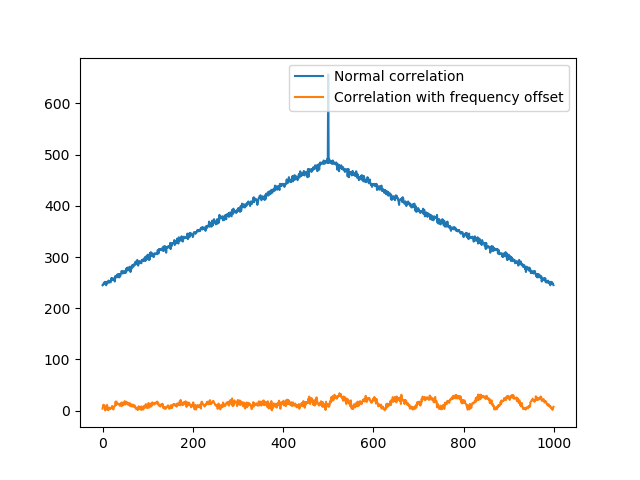

In [68]:
X_with_freq_offset = shift_frequency(X, 0.1)
X_autocorr = numpy.correlate(X, X, mode='same')
X_autocorr_freq_offset = numpy.correlate(X, X_with_freq_offset, mode='same')
pyplot.figure()
pyplot.plot(abs(X_autocorr), label="Normal correlation")
pyplot.plot(abs(X_autocorr_freq_offset), label="Correlation with frequency offset")
pyplot.legend()
pyplot.show()

As you can see, the correlation with a frequency offset doesn't have a large peak anywhere. This is because the frequency offset causes the received signal to "look" significantly different from the transmitted signal, and so the correlation fails to detect the preamble.

The way this is handled in practice is by using a method called "Schmidl-Cox" synchronization. The intuition is that the frequency offset "corrupts" our signal such that we can't detect it using correlation, but if we were to send two copies of the preamble back-to-back, then we would receive two copies of the corrupted preamble back-to-back. Then, instead of searching for a specific signal, we can search for any signal that repeats in time.

Let $L$ be the length of the repeated segment. Then the preamble has length $2L$. At each index $d$ of the signal $s$, the Schmidl-Cox algorithm calculates the following two values:
$$ P(d) = \sum_{m=0}^{L - 1} s_{d + m}^* s_{d + m + L} $$
$$ R(d) = \frac{1}{2} \sum_{m=0}^{2L - 1} \left| s_{d + m} \right|^2 $$

Then the metric calculated at each index is

$$ M(d) = \frac{\left| P(d) \right|^2}{R(d)^2} $$

Intuitively, $P$ is a correlation between the next $L$ samples and the following $L$ samples and $R$ is a normalization factor. Once the value of $M$ increases beyond a threshold, the preamble is detected. Note that $P$ also has a recursive form:

$$ P(d + 1) = P(d) + (s_{d + L}^* s_{d + 2L}) - (s_{d}^* s_{d + L}) $$

**Food for thought**: How could we use a Schmidl-Cox preamble to estimate the frequency offset? This may not be immediatly obvious, but we will do this in Lab 4 to estimate and then correct frequency offsets for when we're receiving data.

### Problem 1.3 Schmidl-Cox Preamble Detection (10 pts)
- **Implement the Schmidl-Cox preamble detector below.**

You can use either the iterative or recursive formulations for calculating $P$. Return the index $d^*$ that maximizes $M(d)$ if $M(d^*)$ is greater than the threshold, otherwise return None.

In [82]:
schmidl_cox_threshold = 0.5
def detect_preamble_with_freq_offset(signal, short_preamble_len):
    pass

In [85]:
# This cell will test your implementation of `detect_preamble`
short_preamble_length = 100
signal_length = 1000
short_preamble = numpy.exp(2j * numpy.pi * numpy.random.random(short_preamble_length))
preamble = numpy.tile(short_preamble, 2)
noise = numpy.random.normal(size=signal_length) + 1j * numpy.random.normal(size=signal_length)
signalA = 0.1 * noise
signalB = 0.1 * noise
signalC = 0.1 * noise
preamble_start_idx = 321
signalB[preamble_start_idx:preamble_start_idx + len(preamble)] += preamble
signalC[preamble_start_idx:preamble_start_idx + len(preamble)] += shift_frequency(preamble, 0.1)

numpy.testing.assert_equal(detect_preamble_with_freq_offset(signalA, short_preamble_length), None)
numpy.testing.assert_equal(detect_preamble_with_freq_offset(signalB, short_preamble_length), 321)
numpy.testing.assert_equal(detect_preamble_with_freq_offset(signalC, short_preamble_length), 321)

# Part 2: Preamble detection with the HackRF

### Problem 2.1 Offline Preamble Detection (20 pts)

There is a Schmidl-Cox preamble being transmitted every second at frequency 1280 MHz. Using the below API, tune to 1280 MHz at a bandwidth of 100 kHz and record two seconds of data. Tune elsewhere (try 1290 MHz) and record another two seconds of data. You may need to play around with the gain value to get a clean reception.
- **For both signals, plot the signal (real and imaginary components separate) and the values of $M$ from running Schmidl-Cox on each signal**

In [69]:
class Radio:
    def __init__(self, *args, **kwargs):
        self.sdr = SoapySDR.Device(*args, **kwargs)

    def set_sample_rate(self, sample_rate_hz):
        self.sdr.setSampleRate(SOAPY_SDR_RX, 0, sample_rate_hz)

    def set_center_frequency(self, freq_hz):
        self.sdr.setFrequency(SOAPY_SDR_RX, 0, freq_hz)

    def start_receive(self):
        self.rx_stream = self.sdr.setupStream(SOAPY_SDR_RX, SOAPY_SDR_CF32)
        self.sdr.activateStream(self.rx_stream)

    def stop_receive(self):
        self.sdr.deactivateStream(self.rx_stream)
        self.sdr.closeStream(self.rx_stream)
        self.rx_stream = None

    def grab_samples(self, rx_buff):
        if self.rx_stream is None:
            raise RuntimeError("Need to start receiving before grabbing samples")

        if len(rx_buff) > self.get_buffer_size():
            raise RuntimeError("Number of samples cannot be more than the buffer size")

        resp = self.sdr.readStream(self.rx_stream, [rx_buff], numElems=len(rx_buff))
        if resp.ret != len(rx_buff):
            raise RuntimeError('Receive failed: {}'.format(SoapySDR.errToStr(resp.ret)))

    def get_buffer_size(self):
        return 131072
    
    def set_receive_gain(self, gain):
        """
        `gain` is a value between 0 and 1. Note that `gain` corresponds to a value in decibels,
        so the actual gain is exponential in the value of `gain`.
        """
        max_rx_gain = sum(self.sdr.getGainRange(SoapySDR.SOAPY_SDR_RX, 0, gain_type).maximum()
            for gain_type in self.sdr.listGains(SoapySDR.SOAPY_SDR_RX, 0))
        self.sdr.setGain(SoapySDR.SOAPY_SDR_RX, 0, gain * max_rx_gain)

### Problem 2.2 Real-time Preamble Detection (Optional) (5 pts)
Run Schmidl-Cox in real time to detect the preamble. Since performing the calculations in python is slow, to get this to work it is necessary to vectorize the calculation of $P$ and to ignore the normalization term (so this is really a variant of Schmidl-Cox).

To receive the bonus points for this optional problem, demonstrate your real-time preamble detection to a TA during lab hours.

# Part 3: Slotted-ALOHA Capacity

In the idealized slotted aloha model, time is splitted into multiple slots and the packet transmission time is one full slot. All nodes are perfectly syncronized, and transmit at the begining of each slot. The transmission probability for each user for each slot is some value $p$.

For each time slot, three cases may happen. 1): There are more than one nodes transmits, thus resulting in a conflict slot. The receiver cannot receive them correctly. 2): There is only one node transmission and thus the receiver can receive it correctly. 3): No node transmits at the current slot.

In this section, we will verify the slotted-ALOHA capacity curve through Monte-Carlo simulation.

### Problem 3.1 Slotted ALOHA Simulation (10 pts)
- **Fill in the function below.**

The function will take a number of users, a number of time slots, and a probability $p$ that a given user will transmit on a given timeslot. The function will return the ratio of successful timeslots (timeslots in which a successful transmission occurred) to total number of timeslots.

In [ ]:
def simulate_slotted_aloha(num_users, num_timeslots, per_slot_user_prob):
    pass

### Problem 3.2 Verifying Slotted ALOHA capacity (5 pts)
Run your simulation over 1000 values of $p$ between 0 and 1 with 10 users and 10k timeslots.
- **Plot the timeslot success ratio as a function of $p$ **

Verify that the resulting plot matches the theoretical curve.